In [1]:
#importing necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc


import warnings
warnings.filterwarnings("ignore")

from matplotlib import style
style.use("ggplot")

import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



from fuzzywuzzy import fuzz
from nltk.tokenize import word_tokenize

import spacy
from tqdm import tqdm
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
! pip install gc
! pip install distance
! pip install fuzzywuzzy
! pip install python-levenshtein
! pip install spacy
! pip install regex
! pip install nltk

spacy.cli.download("en_core_web_lg")


In [2]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Quora Question Pair Similarity

**Quora** is a online platform for asking questions and providing answers.Its head quarter is in Mountain View ,California.It was founded on **june 25,2009** and made available to public on **june 21,2010**.

So in todays generation, quora has emerged as a very huge and usefull platform which is used in different fields.

## `Problem Statement :-`
Whenever the question is asked in quora it might be possible that this question or any similar questions has been already asked and  solved in quora.So in order to provide ease to users we need to identify whether the given pair of question is similar or not.By help of this any user can get the answer to their question very quickly if we are able to find whether any question is similar to his/her question or not


## Content :

- So In this kernel We have performed `Feature Engineering` which can be divided into two parts i.e  Basic Feature Engineering and Advance Feature Engineering

- **`Exploratory Data Analysis`** Technique is Used to analyse created Features
- **`Text Analytics Technique`** Which can be divided into further sub-categories
      


    - Cleaning of Text : Removind Hyperlinks,punctuation and stopwords
    - ***Tokenization*** and ***Stemming***
    - vectorizing the text using `tfidf` vectorizer
    



- **`Model Evaluation`**
> In this section We have made two models `Logistic Regression` and `XgboostClassifier` and compare scores of both and then do some hyperparameter tuning of xgboost model and concluded our Final Model

## Data Understanding and Visualization

In this section we will get a quick look at Data and get few insights by visualizing the data 

In [3]:
#reading data
df=pd.read_csv("train.csv")

In [4]:
print("The shape of data is ",df.shape)
df.head()

The shape of data is  (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


 **Our Original data contains 6 columns and 404290 rows where the resepective columns meanings given as follow:**
 
In two columns **`question1`** and **` question2`** there are given two questions respectively which we need to classify as similar or dissimilar
 
- **`id`**: specific id given to each pair of questions.similar to serial number
- **`qid1`**: id of question 1
- **`qid2`**: id of question 2

 
 

In [5]:
#checking the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**We will see balance of our target variable**

In [6]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

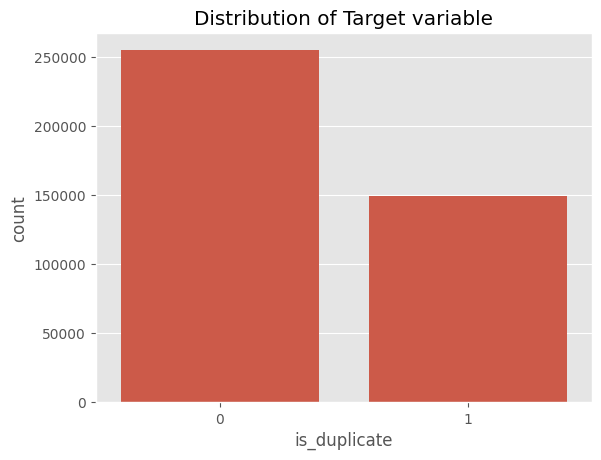

In [7]:
sns.countplot(x=df['is_duplicate'])
plt.title("Distribution of Target variable")
plt.show()

L**ets see the unique number of questions**

In [8]:
question_ids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
no_of_unique_ques=question_ids.nunique()


print("Total number of Unique Questions is",no_of_unique_ques)


Total number of Unique Questions is 537933


**We will find out how many questions are repeated more than once in the dataset**

In [9]:
count_df=question_ids.value_counts()

print("total number of question occuring more than once is",(count_df>1).sum())

total number of question occuring more than once is 111780


**Visualizing the questions**

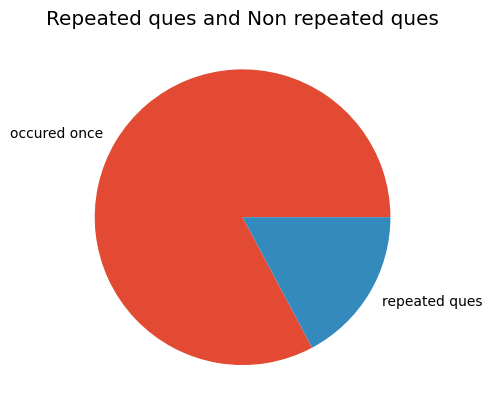

In [10]:
plt.pie([no_of_unique_ques,(count_df>1).sum()],labels=['occured once','repeated ques'])
plt.title("Repeated ques and Non repeated ques")
plt.show()

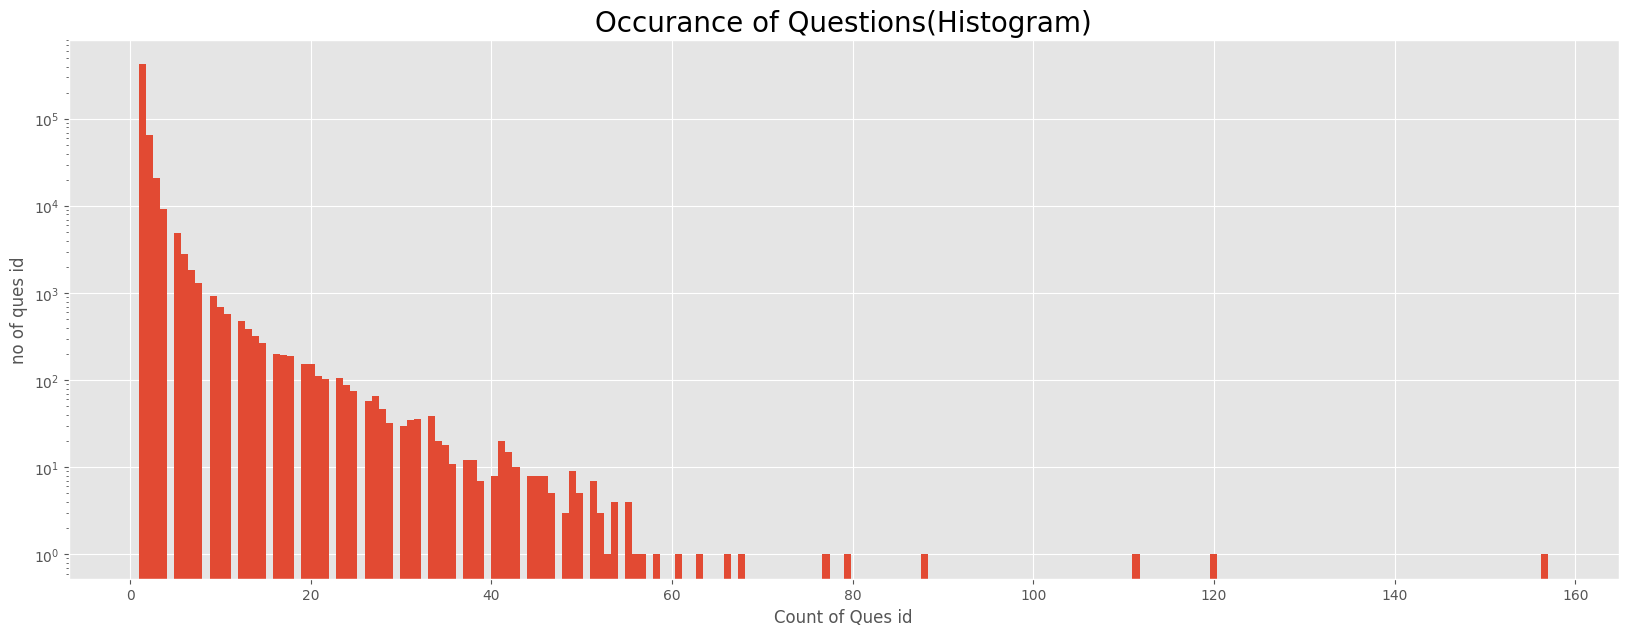

In [11]:
plt.figure(figsize=(20,7))
plt.hist(count_df,bins=200)
plt.yscale("log")
plt.title("Occurance of Questions(Histogram)",size=20)
plt.xlabel("Count of Ques id")
plt.ylabel("no of ques id")
plt.show()

This plot shows distribution of counts of questions i.e x-axis indicates total occurance of questions and y-axis indicates how many question_ids occured.
for eg. we can see highest point in x-axis which is slightly less than 160 which means only single ques_id occured that much time

## Looking for Missing Values

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

As there are very less number of missing values we will drop it

In [13]:
df.dropna(axis=0,inplace=True)

In [14]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Basic feature Engineering

In this section We will create some basic feature which are :-
- **`freq_qid1`**- the number of times question 1 is occured in dataset
- **`freq-qid2`**- the number of times question 2 is occured in dataset
- **`q1len`**- length of question 1
- **`q2len2`**-length of question 2
- **`q1_n_words`**- number of words in question 1
- **`q2_n_words`**- number of words in question 2
- **`words common`**- number of words common in question1 and question2
- **`total_words`**- total number of words in both questions
- **`words_share`**- ratio of common words to total words


In [15]:
df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
df['q1len']=df['question1'].str.len()
df['q2len']=df['question2'].str.len()
df['q1_n_words']=df['question1'].apply(lambda x:len(x.split(" ")))
df['q2_n_words']=df['question2'].apply(lambda x:len(x.split(" ")))




In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [17]:
def words_common(row1,row2):
    a=set(row1.split(" "))
    b=set(row2.split(" "))
    return len(a&b)

def total_words(row1,row2):
    a=set(row1.split(" "))
    b=set(row2.split(" "))
    return len(a)+len(b)

df['words_common']=df.apply(lambda x:words_common(x['question1'],x['question2']),axis=1)
df['words_total']=df.apply(lambda x:total_words(x['question1'],x['question2']),axis=1)
df['words_share']=df.words_common/df.words_total

In [18]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


so we have successfully created few basic features .Later we will also create some advance feature

## Visualizing extracted features

**In this section we will visualize whether a classifying power of features which we created and also we will check distribution of feature**

**`Words share`**

<AxesSubplot: xlabel='words_share', ylabel='Density'>

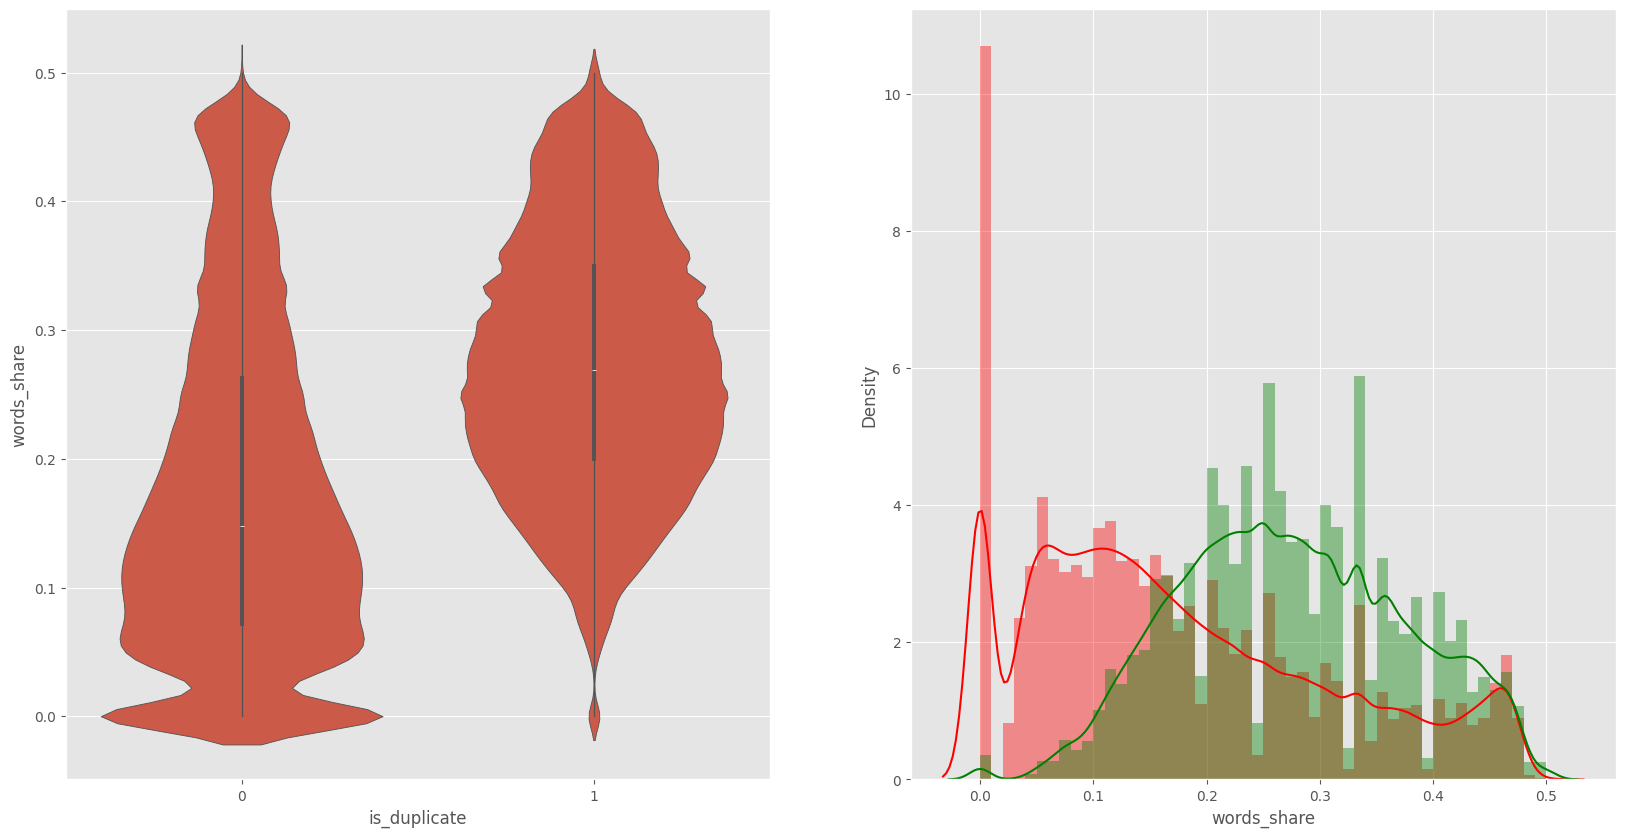

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.violinplot(x=df.is_duplicate,y='words_share',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df.is_duplicate==0]['words_share'],label=0,color='red')
sns.distplot(df[df.is_duplicate==1]['words_share'],label=1,color='green')


so we can the distribution of words share for class 0 and distribution of words share for class 1 is overlapping little.
It means words share can be classify in class 0 and class 1 quite well



**`Words common`**

<AxesSubplot: xlabel='words_common', ylabel='Density'>

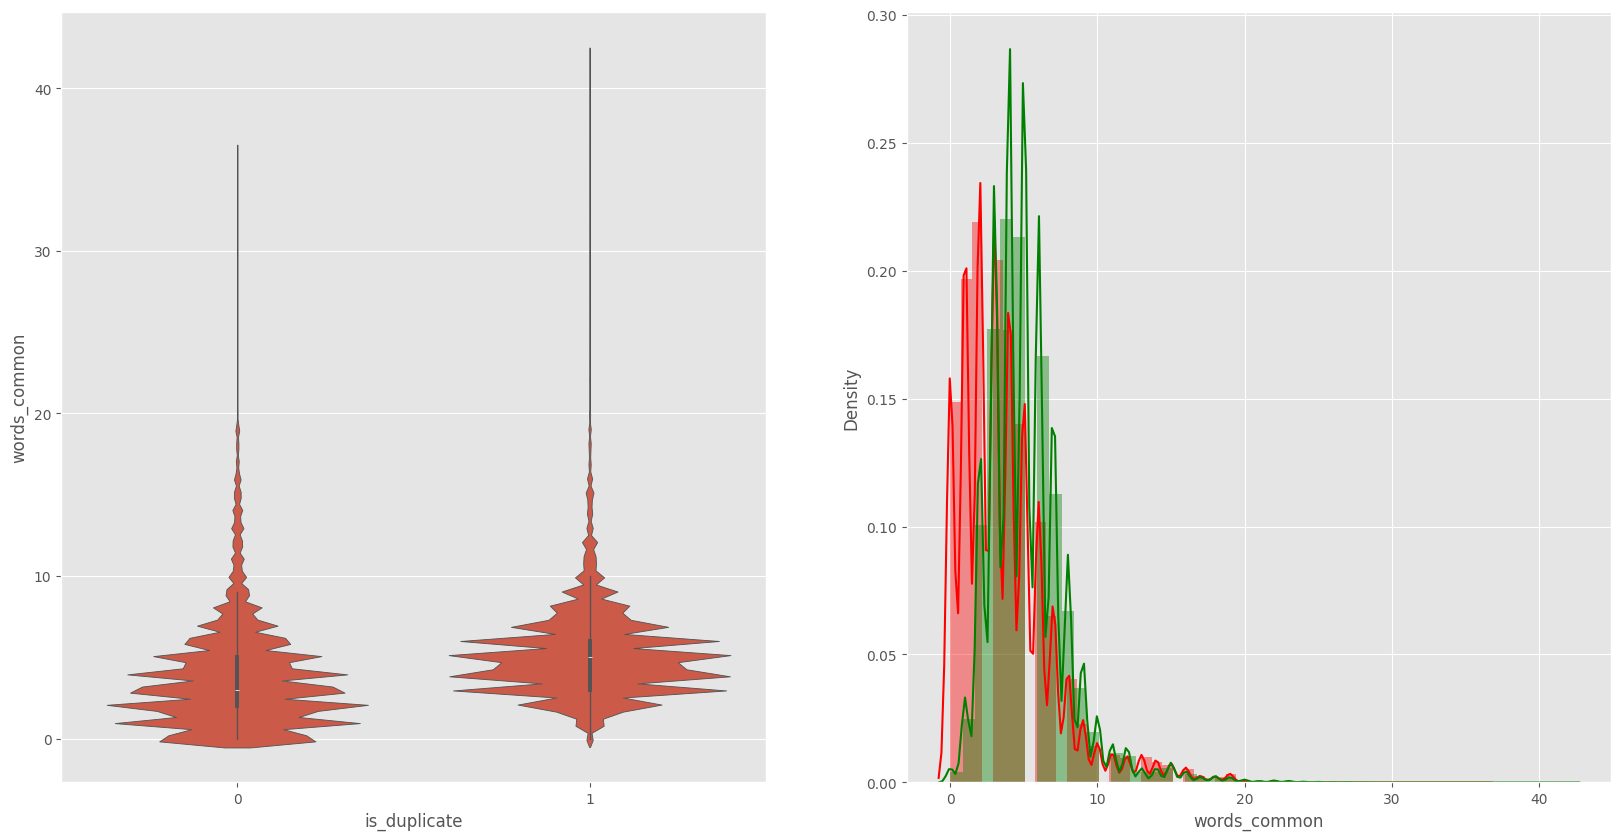

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.violinplot(x=df.is_duplicate,y='words_common',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df.is_duplicate==0]['words_common'],label=0,color='red')
sns.distplot(df[df.is_duplicate==1]['words_common'],label=1,color='green')

# Advance Feature Engineering and Text preprocessing

In the Text preprocessing part,it consists of cleaning the text(expanding contracted words, removing punctuation and links)

and in the feature engineering part we will perform tokenization,stemming,and we will also remove stopwords later. 

**`Tokenization`**-It means breaking the whole text into small parts.it is of two types word tokenization(breaking sentences into words) and sentence tokenization(breaking long text into sentences).

**`stemming`**-stemming means getting the words in their base form.for examles if we the word 'follow' can have different form such as 'follows',  'following' , 'followed' so in stemming we will reduced all these words to  its base form which is 'follow'



we will create a dictionary for contracted words so we can replace them

In [21]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

In [22]:
#defining a function to expand contracted words
def contract_expand(text):
    new_text=""
    text=text.lower()
    for word in text.split():
        if word in CONTRACTION_MAP.keys():
            new_text=new_text+CONTRACTION_MAP[word]
            new_text=new_text+" "
        else:
            new_text=new_text+word
            new_text=new_text+" "
    return new_text

In [23]:
#checking our function
sample_text="I dON't eat banana"
contract_expand(sample_text)

'i do not eat banana '

**Now we will apply this function to our dataset for qustion1 and question2** 

In [24]:
df['question1']=df.question1.apply(contract_expand)
df['question2']=df.question2.apply(contract_expand)

**Removing punctuation**

In [25]:
#defining function
def remove_punctuation_and_links(text):
    pattern1=re.compile('https?\S+|www.\S+|#[a-zA-Z0-9]+')
    text=re.sub(pattern1,"",text)
    pattern2="[^\w\s]"
    
    return re.sub(pattern2,"",text)


In [26]:
sample_text="What a shot! Sky is in absolute form this year. (sky is nickname for surya kumar yadav .for refrence \
            https://en.wikipedia.org/wiki/Suryakumar_Yadav)"
remove_punctuation_and_links(sample_text)

'What a shot Sky is in absolute form this year sky is nickname for surya kumar yadav for refrence             '

we can see our function can remove punctuation and linnks from text so we will apply these also on dataset

In [27]:
%%time

df['question1']=df.question1.apply(remove_punctuation_and_links)
df['question2']=df.question2.apply(remove_punctuation_and_links)

CPU times: total: 8.98 s
Wall time: 9.06 s


##  Word Tokenization and Stemming

so first we will tokenize the text then we will apply stemming on these text

In [28]:
ps=PorterStemmer()

def stem(text):
    tokens=text.split()
    token_stemmed=[ps.stem(word) for word in tokens]
    new_text=remove_punctuation_and_links(str(token_stemmed))
    return new_text

In [29]:
#checking our stem function
a="my name is rahul ,i follow arijit singh and i m followed by my juniors"

stem(a)

'my name is rahul i follow arijit singh and i m follow by my junior'

Lets apply this on dataset now 

In [30]:
%%time
df['question1']=df.question1.apply(stem)


CPU times: total: 37.4 s
Wall time: 37.7 s


In [31]:
%%time
df['question2']=df.question2.apply(stem)

CPU times: total: 37.8 s
Wall time: 38.1 s


we will remove stopwords letter as we want to make few features related to **stopwords** presents

# Advance Feature Creation

We will make few more features which may be very usefull features in classifying the pair of questions.
These are :-

- **`cwc min`** : Ratio of common word count to min length of word count of Q1 and Q2
- **`cwc min`** : Ratio of common word count to max length of word count of Q1 and Q2
- **`csc min`** : Ratio of common stop word count to min length of stop count of Q1 and Q2
- **`csc min`** : Ratio of common stop word count to max length of stop count of Q1 and Q2
- **`last word eq`** : wheather last word is same or not
- **`first word eq`** : whether first word is same or not
- **`abs len diff`** : Absoulute length difference
- **`mean length`** : average total length of both question

**We will create some more features which calculate edit distance between  two strings which can tell us how much similar the two strings is**

- **`fuzz ratio`** : edit distance between two questions
- **`fuzz partial ratio`** : The partial ratio helps us to perform substring matching. This takes the shortest string and compares it with all the substrings of the same length
- **`token_sort_ratio`** : edit distance between two string after sorting the whole strings alphabetically(lower case and punctuation removed)
- **`token_set_ratio`** :Token set ratio performs a set operation that takes out the common tokens instead of just tokenizing the strings, sorting, and then pasting the tokens back together

In [33]:
#creating features
import nltk
nltk.download('stopwords')

stopword=stopwords.words('english')

def get_features(q1,q2):
    
    token_features=[0]*10
    
    #converting strings to tokens
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    
    
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    
    #getting words without stopwords
    q1_words=set(word for word in q1_tokens if word not in stopword)
    q2_words=set(word for word in q2_tokens if word not in stopword)
    
    #getting stopwords
    q1_sw=set(word for word in q1_tokens if word in stopword)
    q2_sw=set(word for word in q2_tokens if word in stopword)
    
    token_features[0]=len(q1_words&q2_words)/(min(len(q1_words),len(q2_words))+0.0001)
    token_features[1]=len(q1_words&q2_words)/(max(len(q1_words),len(q2_words))+0.0001)
    token_features[2]=len(q1_sw&q2_sw)/(min(len(q1_sw),len(q2_sw))+0.0001)   #for safe division
    token_features[3]=len(q1_sw&q2_sw)/(max(len(q1_sw),len(q2_sw))+0.0001)
    token_features[4]=len(set(q1_tokens)&set(q2_tokens))/(min(len(q1_tokens),len(q2_tokens))+0.0001)
    token_features[5]=len(set(q1_tokens)&set(q2_tokens))/(max(len(q1_tokens),len(q2_tokens))+0.0001)
    
    token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])
    token_features[7]=int(q1_tokens[0]==q2_tokens[0])
    token_features[8]=len(q1_tokens)-len(q2_tokens)
    token_features[9]=(len(q1_tokens)+len(q2_tokens))/2
    
    
    return token_features
        
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\INTEL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [34]:
%%time

print("Creating features....")
df['cwc_min']=df.apply(lambda x:get_features(x['question1'],x['question2'])[0],axis=1)
df['cwc_max']=df.apply(lambda x:get_features(x['question1'],x['question2'])[1],axis=1)
df['csc_min']=df.apply(lambda x:get_features(x['question1'],x['question2'])[2],axis=1)
df['csc_max']=df.apply(lambda x:get_features(x['question1'],x['question2'])[3],axis=1)
df['ctc_min']=df.apply(lambda x:get_features(x['question1'],x['question2'])[4],axis=1)
df['ctc_max']=df.apply(lambda x:get_features(x['question1'],x['question2'])[5],axis=1)
df['last_word_eq']=df.apply(lambda x:get_features(x['question1'],x['question2'])[6],axis=1)
df['first_word_eq']=df.apply(lambda x:get_features(x['question1'],x['question2'])[7],axis=1)
df['abs_diff']=df.apply(lambda x:get_features(x['question1'],x['question2'])[8],axis=1)
df['mean_length']=df.apply(lambda x:get_features(x['question1'],x['question2'])[9],axis=1)

Creating features....
CPU times: total: 3min 35s
Wall time: 3min 36s


In [35]:
pd.set_option("display.max_columns",None)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_diff,mean_length
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,14,12,10,23,0.434783,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,8,13,4,20,0.200000,0.666644,0.249997,0.666644,0.499988,0.499994,0.307690,0,1,-5,10.5
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,14,10,3,24,0.125000,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0,1,4,12.0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,1,1,50,65,11,9,0,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,10.0
4,4,9,10,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,3,1,76,39,13,7,2,20,0.100000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0,1,6,10.0


In [36]:
#creatuing fuzzy features

print("Creating fuzzy feautures .....")

df['fuzz_ratio']=df.apply(lambda x:fuzz.QRatio(x['question1'],x['question2']),axis=1)
df['fuzz_partial_ratio']=df.apply(lambda x:fuzz.partial_ratio(x['question1'],x['question2']),axis=1)
df['token_sort_ratio']=df.apply(lambda x:fuzz.token_sort_ratio(x['question1'],x['question2']),axis=1)
df['token_set_ratio']=df.apply(lambda x:fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)

Creating fuzzy feautures .....


In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_diff,mean_length,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,14,12,10,23,0.434783,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,92,100,92,100
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,8,13,4,20,0.200000,0.666644,0.249997,0.666644,0.499988,0.499994,0.307690,0,1,-5,10.5,66,74,64,81
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,14,10,3,24,0.125000,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0,1,4,12.0,54,56,66,73
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,1,1,50,65,11,9,0,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,10.0,34,37,36,35
4,4,9,10,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,3,1,76,39,13,7,2,20,0.100000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0,1,6,10.0,45,54,49,68


So we have successfully created all the features

## Analzying and visualizing the extracted features

In [38]:
print("The shape of the data is",df.shape)
print(df.columns)

The shape of the data is (404287, 29)
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'words_common', 'words_total', 'words_share', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_diff', 'mean_length', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')


**Lets plot and check whether fuzzy features are capable of classifying between 0 and 1 or not**

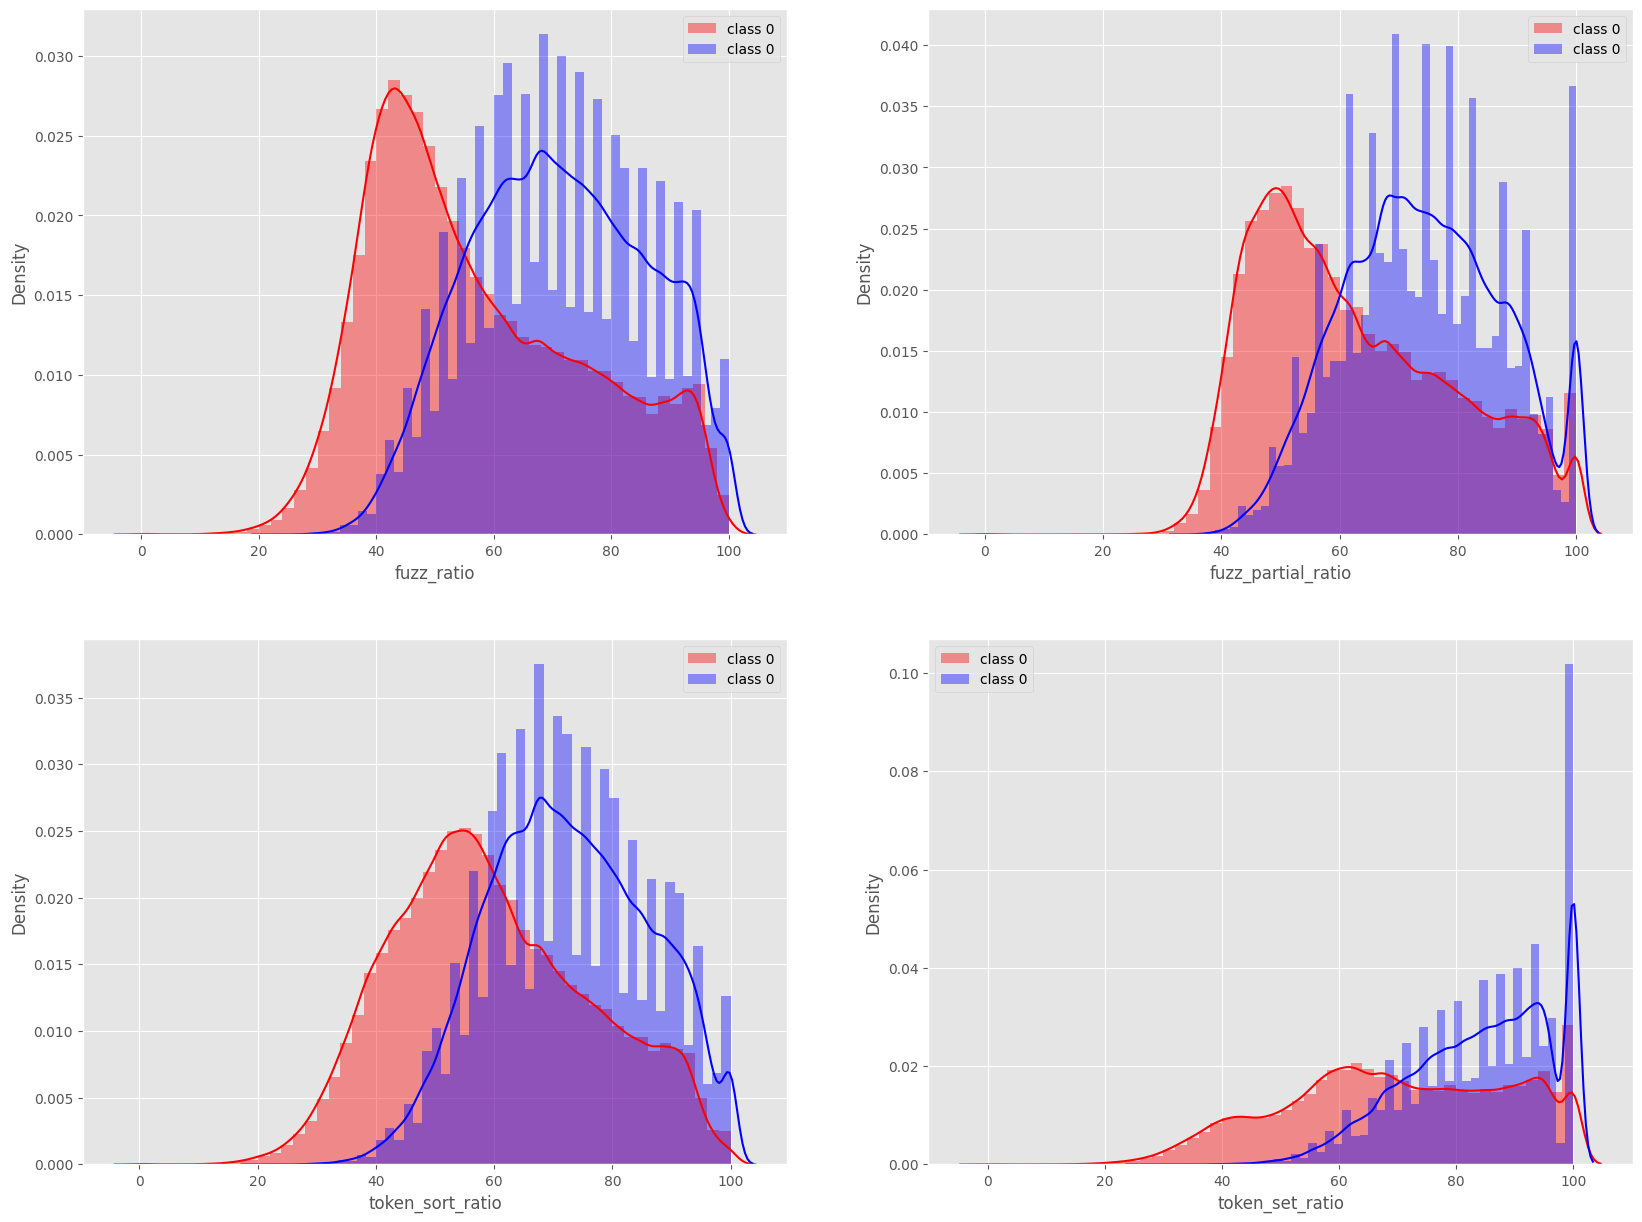

In [39]:
plt.figure(figsize=(20,15))


plt.subplot(2,2,1)
sns.distplot(df[df.is_duplicate==0]['fuzz_ratio'],color='red',label='class 0')
sns.distplot(df[df.is_duplicate==1]['fuzz_ratio'],color='blue',label='class 0')
plt.legend()

plt.subplot(2,2,2)
sns.distplot(df[df.is_duplicate==0]['fuzz_partial_ratio'],color='red',label='class 0')
sns.distplot(df[df.is_duplicate==1]['fuzz_partial_ratio'],color='blue',label='class 0')
plt.legend()

plt.subplot(2,2,3)
sns.distplot(df[df.is_duplicate==0]['token_sort_ratio'],color='red',label='class 0')
sns.distplot(df[df.is_duplicate==1]['token_sort_ratio'],color='blue',label='class 0')
plt.legend()

plt.subplot(2,2,4)
sns.distplot(df[df.is_duplicate==0]['token_set_ratio'],color='red',label='class 0')
sns.distplot(df[df.is_duplicate==1]['token_set_ratio'],color='blue',label='class 0')
plt.legend()


plt.show()

**Plotting pairplot for new features**

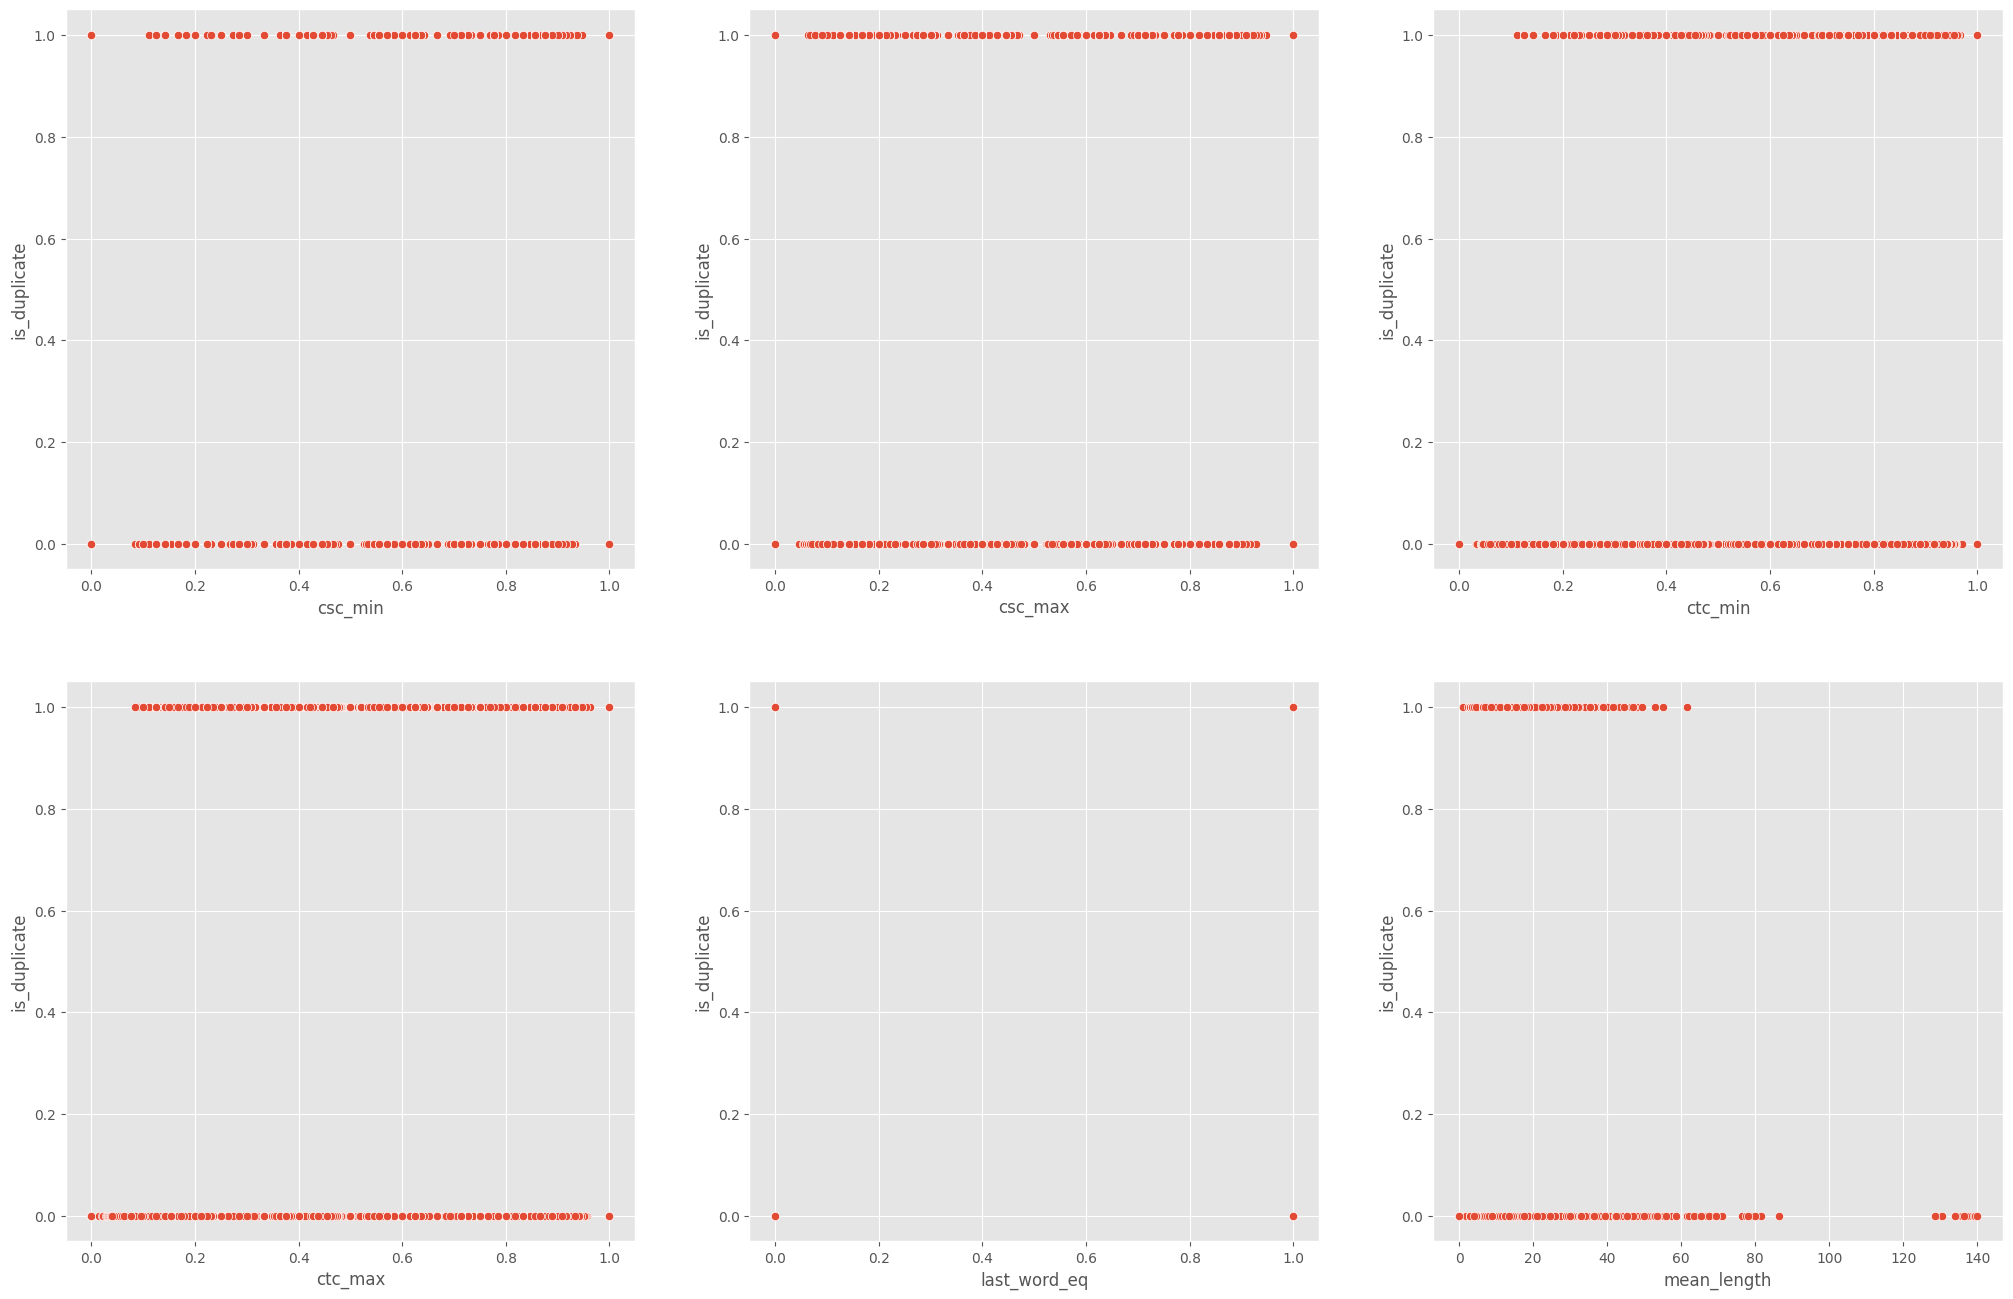

In [40]:
features=['csc_min','csc_max','ctc_min','ctc_max','last_word_eq','mean_length']


fig,axes=plt.subplots(2,3,figsize=(25,16))
axes=axes.ravel()

for feature,ax in zip(features,axes):
     sns.scatterplot(x=df[feature],y=df['is_duplicate'],ax=ax)
   

In [41]:
questions= list(df['question1'])+list(df['question2'])

tfidf=TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word_to_tfidf=dict(zip(tfidf.get_feature_names_out(),tfidf.idf_))

In [42]:
word_to_tfidf

{'00': 10.691005712647282,
 '000': 11.96397138846017,
 '0000': 12.811269248847374,
 '0000000': 13.909881537515483,
 '00000000': 13.909881537515483,
 '0000000000': 13.50441642940732,
 '00000074': 13.909881537515483,
 '0000021210': 13.909881537515483,
 '00001': 13.909881537515483,
 '00002359': 13.909881537515483,
 '00008090100': 13.909881537515483,
 '0002': 13.50441642940732,
 '00035': 13.909881537515483,
 '0008': 13.909881537515483,
 '000v': 13.909881537515483,
 '000webhost': 13.909881537515483,
 '000webhostcom': 13.909881537515483,
 '001': 11.96397138846017,
 '00113': 13.909881537515483,
 '0012': 13.909881537515483,
 '0015': 13.909881537515483,
 '001gbp': 13.909881537515483,
 '002': 12.993590805641327,
 '0020': 13.909881537515483,
 '0021': 13.909881537515483,
 '0025': 13.909881537515483,
 '003': 13.50441642940732,
 '0038': 13.909881537515483,
 '004': 13.216734356955538,
 '005': 12.811269248847374,
 '005246': 13.909881537515483,
 '00569': 13.909881537515483,
 '006': 13.50441642940732,
 

In [43]:
glove_nlp=spacy.load("en_core_web_lg")

len(glove_nlp("sweet").vector)
    

300

In [44]:
def get_weighted_vectors(data,column):
    vectors=[]
    for sentence in tqdm(list(data[column])):
        doc=glove_nlp(sentence)
        mean_vector=np.zeros([len(doc),300])
        for word in doc:
            vec=word.vector
            try:
                idf=word_to_tfidf[str(word)]
            except:
                idf=0
            mean_vector += vec*idf
        mean_vector=mean_vector.mean(axis=0)
        vectors.append(mean_vector)
    return(list(vectors))
            
    

In [45]:
%%time
df['q1_vectors']=get_weighted_vectors(df,'question1')

100%|██████████| 404287/404287 [23:10<00:00, 290.67it/s]


CPU times: total: 22min 55s
Wall time: 23min 11s


In [46]:
%%time
df['q2_vectors']=get_weighted_vectors(df,'question2')

100%|██████████| 404287/404287 [23:36<00:00, 285.43it/s]


CPU times: total: 23min 21s
Wall time: 23min 36s


In [47]:
del word_to_tfidf
gc.collect()

1088

In [48]:
del glove_nlp
gc.collect()

15233

In [49]:
del questions
del tfidf
gc.collect()

0

In [50]:
print("Shape of the data is ",df.shape)
df.head()

Shape of the data is  (404287, 31)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_diff,mean_length,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,q1_vectors,q2_vectors
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,14,12,10,23,0.434783,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,92,100,92,100,"[-31.57733690738678, 82.80076187849045, -232.3...","[-21.018922328948975, 89.28873234987259, -220...."
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,8,13,4,20,0.200000,0.666644,0.249997,0.666644,0.499988,0.499994,0.307690,0,1,-5,10.5,66,74,64,81,"[-67.68589770793915, 18.5176420211792, -36.385...","[-116.88892436027527, 60.68805742263794, -108...."
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,14,10,3,24,0.125000,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0,1,4,12.0,54,56,66,73,"[-31.395021617412567, 118.54739239811897, -166...","[-36.966034308075905, 33.050018310546875, -144..."
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,1,1,50,65,11,9,0,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,10.0,34,37,36,35,"[104.06894931197166, 75.94008097052574, -56.90...","[-69.71509838104248, -31.73594903945923, -41.5..."
4,4,9,10,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,3,1,76,39,13,7,2,20,0.100000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0,1,6,10.0,45,54,49,68,"[15.519193470478058, -56.175366044044495, -151...","[1.667830467224121, -5.678200840950012, -102.7..."


Our word vectors are in the form of lists.We will make them as feature. That is for each question we have vector of length 300.So for q1 there will be 300 columns and same for the q2

In [51]:
df=pd.concat((df.reset_index(),pd.DataFrame(list(df['q1_vectors']))),axis=1)
df=pd.concat((df,pd.DataFrame(list(df['q2_vectors']))),axis=1)

In [52]:
print("Shape of dataframe is ",df.shape)
df.head()

Shape of dataframe is  (404287, 632)


,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_diff,mean_length,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,q1_vectors,q2_vectors,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,14,12,10,23,0.434783,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,92,100,92,100,"[-31.57733690738678, 82.80076187849045, -232.3...","[-21.018922328948975, 89.28873234987259, -220....",-31.577337,82.800762,-232.309936,-14.999555,146.092482,56.250952,-73.834648,163.627836,-195.656940,-15.893923,379.111154,179.852073,-368.998951,111.987247,-68.735959,165.856659,109.263619,149.500068,-68.853614,-181.536880,68.163769,-82.614512,-145.269743,-99.273783,-145.238024,-41.653100,-78.247419,-93.434348,53.972453,24.918277,170.029221,-41.932139,-88.931710,-47.127977,-14.632861,-65.797736,-0.821128,256.058570,24.944716,-28.466881,-78.677437,65.679838,-7.353886,-2.928583,-97.976117,144.422394,172.765503,-151.104437,35.914005,77.920191,-28.945888,162.019023,-39.059017,-359.648755,-20.248777,44.146564,-86.074916,45.144788,95.718570,11.654685,124.710159,-59.449054,-24.065833,27.564495,194.676854,193.795792,-62.853805,-306.007754,25.676383,236.695620,-18.683105,47.946537,-87.781891,-37.481864,-105.198359,200.563586,-133.620715,227.115857,-210.143166,64.852178,-222.978574,54.359524,110.090634,-5.342731,75.104750,138.940635,-124.470924,-65.637362,176.212600,-50.219712,-17.296823,-38.942314,16.051612,-283.124437,34.286124,-135.343592,-36.801521,-11.626006,58.425503,171.764296,451.625264,165.037822,189.203032,139.583942,100.344209,176.562263,-106.677581,-

In [53]:
df.isnull().sum()

index        0
id           0
qid1         0
qid2         0
question1    0
            ..
295          9
296          9
297          9
298          9
299          9
Length: 632, dtype: int64

There are few rows in our dataframe for which question1 column and question2 columns is empty.Thats why it showing null after getting vectors.We will drop these rows later as the number of rows is negligible

In [54]:
df.dropna(inplace=True)

Our Final DataFrame is ready.Now we can proceed to Model Evaluation part

##  Model Evaluation

In this part we will develop few models based on Machine Learning algorithm to predict whether the given pair of questions is duplicate or not.We will use our extracted feature(Basic+advance) to predict target column .we will see some metrics to know how well our model is performing and also we will compare performance of our differenc Models

In [55]:
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,words_common,words_total,words_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_diff,mean_length,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,q1_vectors,q2_vectors,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,14,12,10,23,0.434783,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,92,100,92,100,"[-31.57733690738678, 82.80076187849045, -232.3...","[-21.018922328948975, 89.28873234987259, -220....",-31.577337,82.800762,-232.309936,-14.999555,146.092482,56.250952,-73.834648,163.627836,-195.656940,-15.893923,379.111154,179.852073,-368.998951,111.987247,-68.735959,165.856659,109.263619,149.500068,-68.853614,-181.536880,68.163769,-82.614512,-145.269743,-99.273783,-145.238024,-41.653100,-78.247419,-93.434348,53.972453,24.918277,170.029221,-41.932139,-88.931710,-47.127977,-14.632861,-65.797736,-0.821128,256.058570,24.944716,-28.466881,-78.677437,65.679838,-7.353886,-2.928583,-97.976117,144.422394,172.765503,-151.104437,35.914005,77.920191,-28.945888,162.019023,-39.059017,-359.648755,-20.248777,44.146564,-86.074916,45.144788,95.718570,11.654685,124.710159,-59.449054,-24.065833,27.564495,194.676854,193.795792,-62.853805,-306.007754,25.676383,236.695620,-18.683105,47.946537,-87.781891,-37.481864,-105.198359,200.563586,-133.620715,227.115857,-210.143166,64.852178,-222.978574,54.359524,110.090634,-5.342731,75.104750,138.940635,-124.470924,-65.637362,176.212600,-50.219712,-17.296823,-38.942314,16.051612,-283.124437,34.286124,-135.343592,-36.801521,-11.626006,58.425503,171.764296,451.625264,165.037822,189.203032,139.583942,100.344209,176.562263,-106.677581,-

**There are few columns which is unnecessary for our machine learning algorithm, So lets drop them**

In [56]:
df=df.drop(["index","id","qid1","qid2","question1","question2","q1_vectors","q2_vectors"],axis=1)

In [57]:
gc.collect()

0

**Splitting the data in independent variable(x) and Target variable(y)**

In [58]:
x=df.drop("is_duplicate",axis=1)
y=df["is_duplicate"]

print(x.shape)
print(y.shape)

(404258, 623)
(404258,)


In [59]:
del df
gc.collect()

0

**Splitting the data into training and testing part**

In [60]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [61]:
del x
del y
gc.collect()

0

In [62]:
x_train.columns=x_train.columns.astype(str)
x_test.columns=x_test.columns.astype(str)

**Scaling of Data**

In [63]:

scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

## `Logistic Regression Model`

In [64]:

model1_lr=LogisticRegression()
model1_lr.fit(x_train,y_train)

model1_lr.score(x_test,y_test)

0.7835922426161381

In [65]:

print(metrics.classification_report(y_test,model1_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     50879
           1       0.73      0.66      0.69     29973

    accuracy                           0.78     80852
   macro avg       0.77      0.76      0.76     80852
weighted avg       0.78      0.78      0.78     80852



Our model predicting '0' class better than class '1'

**Plotting Confusion_matrix**

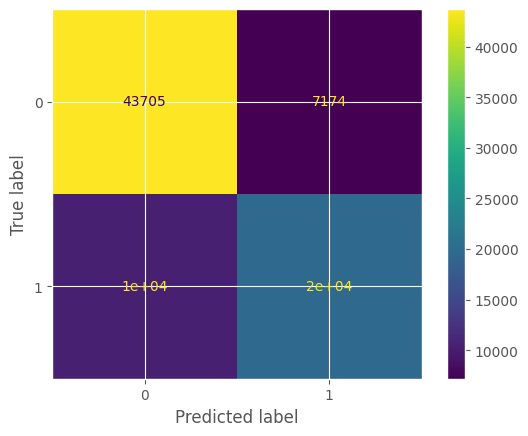

In [66]:

metrics.ConfusionMatrixDisplay.from_estimator(model1_lr,x_test,y_test)


In [67]:
fpr,tpr,threshold=metrics.roc_curve(y_test,model1_lr.predict_proba(x_test)[::,1])

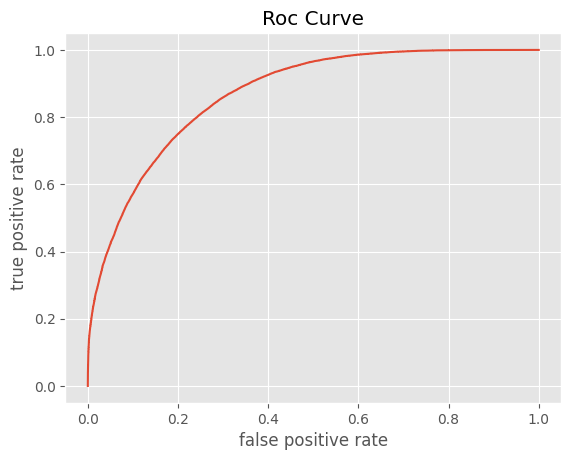

In [68]:
plt.plot(fpr,tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc Curve")
plt.show()



In [69]:
a=metrics.roc_auc_score(y_test,model1_lr.predict_proba(x_test)[::,1])
print("Auc score is ",a)

Auc score is  0.8685191765128434


In [70]:
del model1_lr
gc.collect()

3456

## `XGBoost Classifier`

In [71]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
print("Accuracy score of XGB base model is ",xgb.score(x_test,y_test))

Accuracy score of XGB base model is  0.842057091970514


In [72]:
del xgb
gc.collect()

61

**`Hyperparameter Tuning`**

In [73]:
xgb=XGBClassifier()

search=GridSearchCV(xgb,param_grid={"eta":[0.01,0.05,0.1,0.2]},cv=3)
search.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.01, 0.05, 0.1, 0.2]})

In [74]:
a=pd.DataFrame(search.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,58.497378,1.550256,0.250491,0.055876,0.01,{'eta': 0.01},0.808167,0.805922,0.806506,0.806865,0.000951,4
1,55.048576,0.778253,0.190990,0.020493,0.05,{'eta': 0.05},0.824326,0.825968,0.824938,0.825077,0.000677,3
2,56.454992,0.562696,0.185718,0.011226,0.1,{'eta': 0.1},0.832461,0.834456,0.833621,0.833513,0.000818,2
3,54.738511,0.700535,0.185614,0.003695,0.2,{'eta': 0.2},0.836803,0.839363,0.838352,0.838172,0.001053,1


In [75]:
print("Best score :",search.best_score_)
print("Best parameter : ",search.best_params_)

Best score : 0.8381724519644038
Best parameter :  {'eta': 0.2}


So optimal value of eta is 0.2

In [76]:
del search
gc.collect()

141

In [77]:
search=GridSearchCV(xgb,param_grid={"max_depth":[5,8,12]},cv=3,return_train_score=True)
search.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [5, 8, 12]}, return_train_score=True)

In [78]:
a=pd.DataFrame(search.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,57.030913,8.386750,0.250273,0.031875,5,{'max_depth': 5},0.836487,0.835931,0.836988,0.836469,0.000432,2,0.864144,0.865160,0.863996,0.864434,0.000517
1,89.423548,1.698431,0.239842,0.011978,8,{'max_depth': 8},0.840977,0.840699,0.840708,0.840795,0.000129,1,0.962269,0.961615,0.960622,0.961502,0.000677
2,31.490052,18.426131,0.000000,0.000000,12,{'max_depth': 12},NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN


In [79]:
print("Best score :",search.best_score_)
print("Best parameter : ",search.best_params_)

Best score : 0.8407945430820701
Best parameter :  {'max_depth': 8}


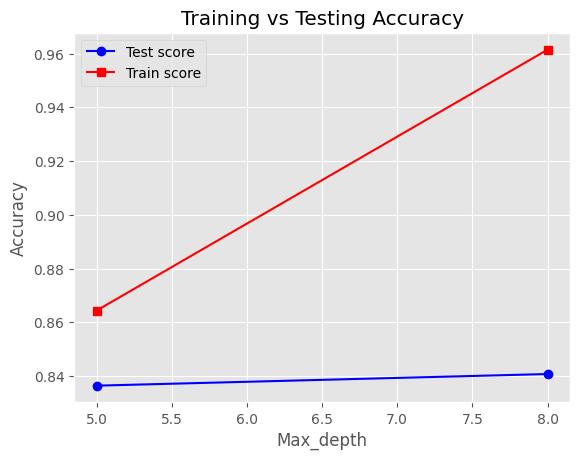

In [80]:
plt.plot(a['param_max_depth'],a["mean_test_score"],color="blue",marker="o",label="Test score")
plt.plot(a["param_max_depth"],a['mean_train_score'],color="red",marker="s",label="Train score")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")
plt.show()

So as max_depth increasing after 5 ,we can observe that training score is very high and testing score is comparitively less i.e situation of **Over Fitting**
Therefore optimal value of max_depth is **5**

In [81]:
del search
gc.collect()

4042

In [82]:
search=GridSearchCV(xgb,param_grid={"max_depth":[5],"eta":[0.2],"n_estimators":[20,50,100]},cv=3,return_train_score=True)

search.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.2], 'max_depth': [5],
                         'n_estimators': [20, 50, 100]},
             return_train_score=True)

In [83]:
a=pd.DataFrame(search.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,17.332280,0.851365,0.178993,0.020595,0.2,5,20,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 20}",0.818538,0.818835,0.819243,0.818872,0.000289,3,0.820750,0.820054,0.821279,0.820694,0.000501
1,31.882389,2.139588,0.176858,0.024278,0.2,5,50,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 50}",0.828825,0.829038,0.829187,0.829017,0.000148,2,0.837531,0.837387,0.836821,0.837246,0.000306
2,58.942717,6.322522,0.257466,0.056130,0.2,5,100,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 100}",0.835597,0.835003,0.836042,0.835547,0.000426,1,0.853927,0.854191,0.853338,0.853818,0.000357


In [84]:
print("Best score :",search.best_score_)
print("Best parameter : ",search.best_params_)

Best score : 0.8355472687581553
Best parameter :  {'eta': 0.2, 'max_depth': 5, 'n_estimators': 100}


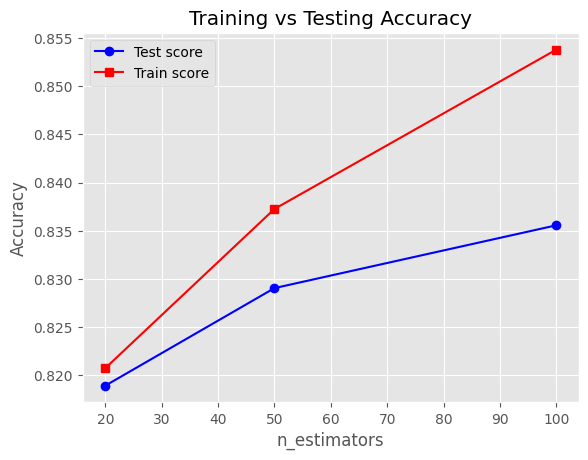

In [85]:
plt.plot(a['param_n_estimators'],a["mean_test_score"],color="blue",marker="o",label="Test score")
plt.plot(a["param_n_estimators"],a['mean_train_score'],color="red",marker="s",label="Train score")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

We should consider 50 as optimal number of estimator as after 50 model is overfitting

In [86]:
del search
gc.collect()

4418

In [87]:
search=GridSearchCV(xgb,param_grid={"max_depth":[5],"eta":[0.2],"n_estimators":[50]
                                   ,"subsample":[0.2,0.5,1]},cv=3,return_train_score=True)

search.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.2], 'max_depth': [5], 'n_estimators': [50],
                         'subsample': [0.2, 0.5, 1]},
             return_train_score=True)

In [88]:
a=pd.DataFrame(search.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,45.227470,2.504854,0.227494,0.028677,0.2,5,50,0.2,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 5...",0.826237,0.827035,0.825476,0.826249,0.000636,3,0.835212,0.834247,0.833398,0.834286,0.000741
1,42.950308,2.285127,0.243461,0.015478,0.2,5,50,0.5,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 5...",0.828139,0.828760,0.829038,0.828646,0.000376,2,0.836548,0.836766,0.836367,0.836560,0.000163
2,44.270822,0.902932,0.208579,0.001296,0.2,5,50,1,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 5...",0.828825,0.829038,0.829187,0.829017,0.000148,1,0.837531,0.837387,0.836821,0.837246,0.000306


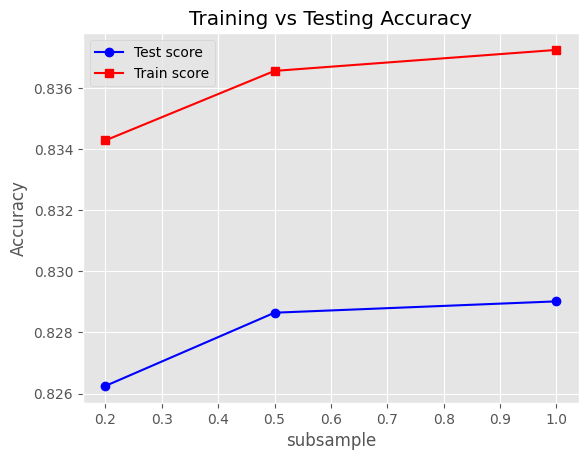

In [89]:
plt.plot(a['param_subsample'],a["mean_test_score"],color="blue",marker="o",label="Test score")
plt.plot(a["param_subsample"],a['mean_train_score'],color="red",marker="s",label="Train score")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.xlabel("subsample")
plt.ylabel("Accuracy")
plt.show()

From here we can see we can take 0.5 as subsample

In [90]:
print("Best score :",search.best_score_)
print("Best parameter : ",search.best_params_)

Best score : 0.8290167776726468
Best parameter :  {'eta': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


**So we tried enough hyperparameter tuning and can conclude that accuracy of model is not improving so far**

In [91]:
del search
del xgb
gc.collect()

4241

### Final Model (XGBoost Classifier)


In [92]:
#making final_model
xgb=XGBClassifier(n_estimators=50,max_depth=5,eta=0.2,subsample=0.5)
xgb.fit(x_train,y_train)

y_pred_prob=xgb.predict_proba(x_test)


In [93]:
print("Accuracy score of final model is :",xgb.score(x_test,y_test))

Accuracy score of final model is : 0.8317666848068075


In [94]:
print(metrics.classification_report(y_test,xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     50879
           1       0.80      0.73      0.76     29973

    accuracy                           0.83     80852
   macro avg       0.82      0.81      0.82     80852
weighted avg       0.83      0.83      0.83     80852



**Plotting Confusion Matrix**

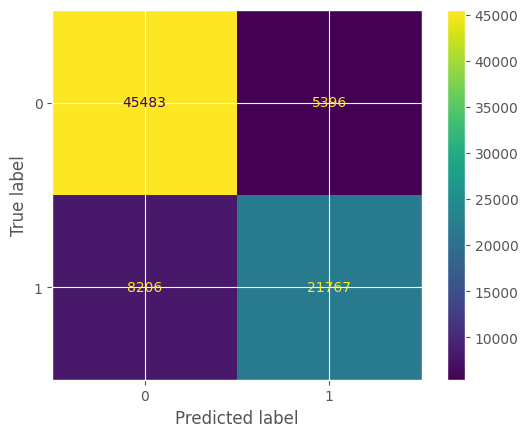

In [95]:
metrics.ConfusionMatrixDisplay.from_estimator(xgb,x_test,y_test)

**Plotting Roc Curve**

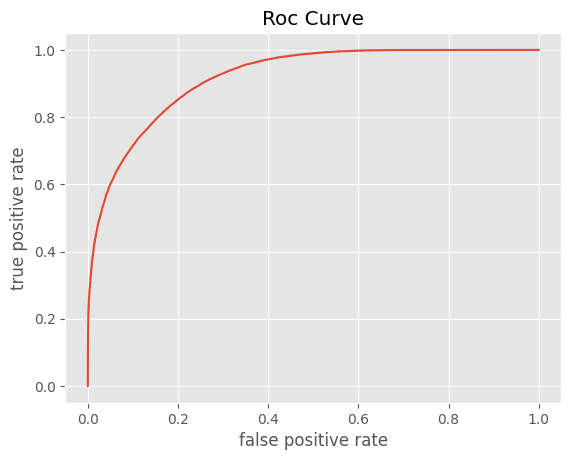

In [96]:
fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred_prob[::,1])


plt.plot(fpr,tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc Curve")
plt.show()

In [97]:
a=metrics.roc_auc_score(y_test,y_pred_prob[::,1])
print("Auc score is ",a)

Auc score is  0.9179422296251432


## `Conclusion : -`

After data cleaning and feature engineering we tried two models 
- Logistic Regression Model
- XgBoostClassifier Model

After **hyperparameter** of Xgboost model the accuracy of model is more or less the same as base model.
Comparing the accuracy of both models we select our xgboost model as final model as accuracy score **83%**(approx)
and **0.91** auc score.


